# Apprenticeship Learning via IRL - Q Learning

## CartPole-v0

[CartPole-v0 Wiki](https://github.com/openai/gym/wiki/CartPole-v0)

In [1]:
import gym
import numpy as np
from tqdm import tqdm
import imageio
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, Image

In [2]:
env = gym.make('CartPole-v0')

nbins = 10    # discretization
GAMMA = 0.9   # discount factor
ALPHA = 0.01  # learning rate

Observations

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -0.418 rad (-24&deg;) | ~ 0.418 rad (24&deg;)
3 | Pole Velocity At Tip | -Inf | Inf

In [3]:
# Discretize the continuous observable state space

bins = np.zeros((4,nbins))

bins[0] = np.linspace(-2.4, 2.4, nbins)    # position
bins[1] = np.linspace(-5, 5, nbins)        # velocity
bins[2] = np.linspace(-.418, .418, nbins)  # angle
bins[3] = np.linspace(-5, 5, nbins)        # tip velocity

In [4]:
# States

states = []

for i in range (nbins+1):
    for j in range (nbins+1):
        for k in range(nbins+1):
            for l in range(nbins+1):
                a=str(i).zfill(2)+str(j).zfill(2)+str(k).zfill(2)+str(l).zfill(2)
                states.append(a)

In [5]:
# Possible states = (nbins+1)^4

len(states)

14641

Actions:
Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right

In [6]:
# Possible actions

env.action_space.n

2

In [7]:
# Initialize Q Table

def init_Q():
    
    Q = {}
    
    for state in states:
        Q[state] = {}
        
        for action in range(env.action_space.n):
            Q[state][action] = 0
    
    return Q

In [8]:
# Discretize observation into bins

def assign_bins(observation, bins):
    
    discretized_state = np.zeros(4)
    
    for i in range(4):
        discretized_state[i] = np.digitize(observation[i], bins[i])
        
    return discretized_state

In [9]:
# Encode state into string representation as a dictionary

def get_string_state(state):

    string_state = ''.join(str(int(e)).zfill(2) for e in state)
    
    return string_state

In [10]:
# Train an episode

def train_an_episode(bins, Q, epsilon=0.5):
    """
    Simulate one episode of training.

    Parameters:
    - bins: Discretization bins for state representation.
    - Q: Q-table for the reinforcement learning agent.
    - epsilon: Exploration-exploitation trade-off parameter.

    Returns:
    - total_reward: Total reward obtained during the episode.
    - move_count: Number of moves in the episode.
    """
    
    observation = env.reset()
    done = False
    move_count = 0   # no. of moves in an episode
    state = get_string_state(assign_bins(observation, bins))
    total_reward = 0

    while not done:
        move_count += 1

        if np.random.uniform() < epsilon:
            action = env.action_space.sample()  # epsilon-greedy exploration
        else:
            action = max(Q[state].items(), key=lambda x: x[1])[0]   # action with max value

        observation, reward, done, _ = env.step(action)

        total_reward += reward

        # penalize early episode termination
        if done and move_count < 200:
            reward = -300

        new_state = get_string_state(assign_bins(observation, bins))

        best_action, max_q_s1a1 = max(Q[new_state].items(), key=lambda x: x[1])
        Q[state][action] += ALPHA * (reward + GAMMA * max_q_s1a1 - Q[state][action])
        state, action = new_state, best_action

    return total_reward, move_count

In [11]:
# Train for many episodes

def q_learning_train(bins, num_episodes=10000, print_interval=1000):
    """
    Train a Q-learning agent through multiple episodes.
    
    Parameters:
    - bins: Discretization bins for state representation.
    - num_episodes: Number of training episodes.
    - print_interval: Interval for printing training progress.
    
    Returns:
    - episode_lengths: List of lengths for each episode.
    - episode_rewards: List of rewards for each episode.
    - Q: Trained Q-table.
    """
    
    Q = init_Q()
    episode_lengths = []
    episode_rewards = []

    for episode in tqdm(range(1, num_episodes + 1), desc="Training Episodes.."):
        epsilon = 1.0 / np.sqrt(episode + 1)

        episode_reward, episode_length = train_an_episode(bins, Q, epsilon)

        if episode % print_interval == 0:
            print(f"Episode: {episode}, Epsilon: {epsilon:.4f}, Reward: {episode_reward}")

        episode_lengths.append(episode_length)
        episode_rewards.append(episode_reward)

    env.close()
    
    return episode_lengths, episode_rewards, Q

In [12]:
# Plot reward curve

def plot_performance(total_rewards, title='Running Average Reward', save=False, filename='result'):
    """
    Plot the running average of rewards during training.

    Parameters:
    - total_rewards: List of total rewards obtained in each episode during training.
    - title: Title of the plot.
    - save: If True, save the plot as an image file.
    - filename: Name (or path) of the file if saving the plot.

    Returns:
    - None
    """
    
    fig = plt.figure()
    num_episodes = len(total_rewards)
    running_avg = np.empty(num_episodes)

    for episode in range(num_episodes):
        running_avg[episode] = np.mean(total_rewards[max(0, episode - 100):(episode + 1)])

    plt.plot(running_avg)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Running Average Reward")

    if save:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
        plt.show()
    else:
        plt.show()

In [13]:
# simulate env using policy

def run_policy(bins, Q, num_episodes=1000, render=False, render_filename='Agent Policy'):
    """
    Run an environment using a trained policy.

    Parameters:
    - bins: Discretization bins for state representation.
    - Q: Trained Q-table.
    - num_episodes: Number of episodes to run the policy.
    - render: If True, render the environment during execution.
    - render_filename: File name (or path) of gif of the render to be saved if rendering.

    Returns:
    - total_rewards: List of total rewards obtained in each episode.
    """
    
    total_rewards = []

    for episode in tqdm(range(num_episodes), desc='Running Policy...'):
        observation = env.reset()
        done = False
        episode_reward = 0

        images = []
        while not done:
            if render:
                img = env.render(mode='rgb_array')
                images.append(img)

            state = get_string_state(assign_bins(observation, bins))
            action = max(Q[state].items(), key=lambda x: x[1])[0]
            observation, reward, done, _ = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)

    if render:
        imageio.mimsave(f'{render_filename}.gif', images, fps=30, loop=0)
        env.close()
        with open(f'{render_filename}.gif', 'rb') as f:
            display(Image(data=f.read(), format='gif'))

    return total_rewards

## Training - Obtain Expert Policy

* Agent is trained using traditional Q-learning to obtain expert policy for Inverse Reinforcement Learning (IRL).

* Rewards from state-action pairs are stored in a 10000 x 2 array, with rows representing states and columns representing actions. Each cell in the array holds the reward associated with a specific state-action pair.

* The algorithm utilizes an epsilon-greedy approach to choose its actions during training iterations.

* The Q table, which is updated iteratively, represents the policy.

In [14]:
episode_lengths, episode_rewards, expert_Q = q_learning_train(bins,num_episodes=30000, print_interval=2000)

Training Episodes..:   7%|█               | 2054/30000 [00:05<01:31, 305.85it/s]

Episode: 2000, Epsilon: 0.0224, Reward: 200.0


Training Episodes..:  13%|██▏             | 4049/30000 [00:12<01:23, 311.03it/s]

Episode: 4000, Epsilon: 0.0158, Reward: 185.0


Training Episodes..:  20%|███▏            | 6043/30000 [00:19<01:18, 303.92it/s]

Episode: 6000, Epsilon: 0.0129, Reward: 200.0


Training Episodes..:  27%|████▎           | 8052/30000 [00:25<01:10, 311.00it/s]

Episode: 8000, Epsilon: 0.0112, Reward: 200.0


Training Episodes..:  34%|█████          | 10054/30000 [00:32<01:04, 307.59it/s]

Episode: 10000, Epsilon: 0.0100, Reward: 200.0


Training Episodes..:  40%|██████         | 12052/30000 [00:38<00:58, 306.87it/s]

Episode: 12000, Epsilon: 0.0091, Reward: 200.0


Training Episodes..:  47%|███████        | 14042/30000 [00:45<00:51, 307.35it/s]

Episode: 14000, Epsilon: 0.0085, Reward: 200.0


Training Episodes..:  53%|████████       | 16040/30000 [00:51<00:46, 302.70it/s]

Episode: 16000, Epsilon: 0.0079, Reward: 200.0


Training Episodes..:  60%|█████████      | 18034/30000 [00:58<00:38, 306.91it/s]

Episode: 18000, Epsilon: 0.0075, Reward: 200.0


Training Episodes..:  67%|██████████     | 20043/30000 [01:04<00:32, 306.84it/s]

Episode: 20000, Epsilon: 0.0071, Reward: 200.0


Training Episodes..:  74%|███████████    | 22060/30000 [01:11<00:25, 307.97it/s]

Episode: 22000, Epsilon: 0.0067, Reward: 200.0


Training Episodes..:  80%|████████████   | 24052/30000 [01:17<00:19, 309.29it/s]

Episode: 24000, Epsilon: 0.0065, Reward: 200.0


Training Episodes..:  87%|█████████████  | 26059/30000 [01:24<00:12, 309.45it/s]

Episode: 26000, Epsilon: 0.0062, Reward: 200.0


Training Episodes..:  93%|██████████████ | 28032/30000 [01:30<00:06, 296.62it/s]

Episode: 28000, Epsilon: 0.0060, Reward: 200.0


Training Episodes..: 100%|███████████████| 30000/30000 [01:37<00:00, 308.47it/s]

Episode: 30000, Epsilon: 0.0058, Reward: 200.0


In [15]:
# function to save
def save(obj,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f)
            print(f'Saved {filename}')
    except Exception as err:
        print(err)
        
# function to load
def load(filename, obj):
    try:
        with open(filename, 'rb') as file:
            obj = pickle.load(file)
        print(f"Loaded {filename}")
        return obj
    except FileNotFoundError as f_err:
        print(f_err)
        return None
    except Exception as e:
        print(e)
        return None

In [16]:
# Save Q table

save(expert_Q, '../Data/Expert_Q_table')

Saved ../Data/Expert_Q_table


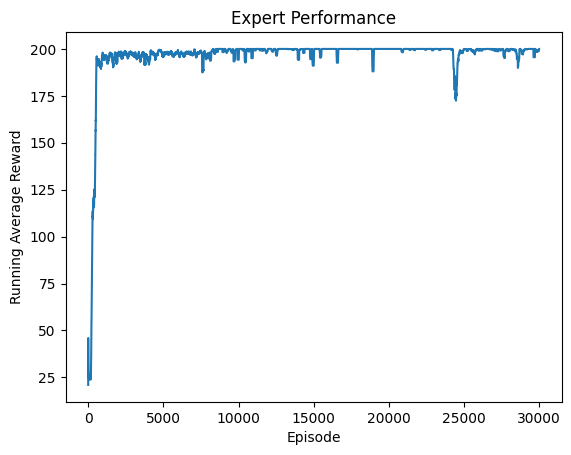

In [17]:
# Plot performance

plot_performance(episode_rewards,title="Expert Performance",save=True,
                 filename='../Results/Expert Performance [Q-Learning]')

In [18]:
# Training result
# Using the learned policy, simulate the environment 1000 times to sample the reward distribution.

expert_reward = run_policy(bins, expert_Q, num_episodes=1000, render=False)

Running Policy...: 100%|███████████████████| 1000/1000 [00:02<00:00, 339.98it/s]


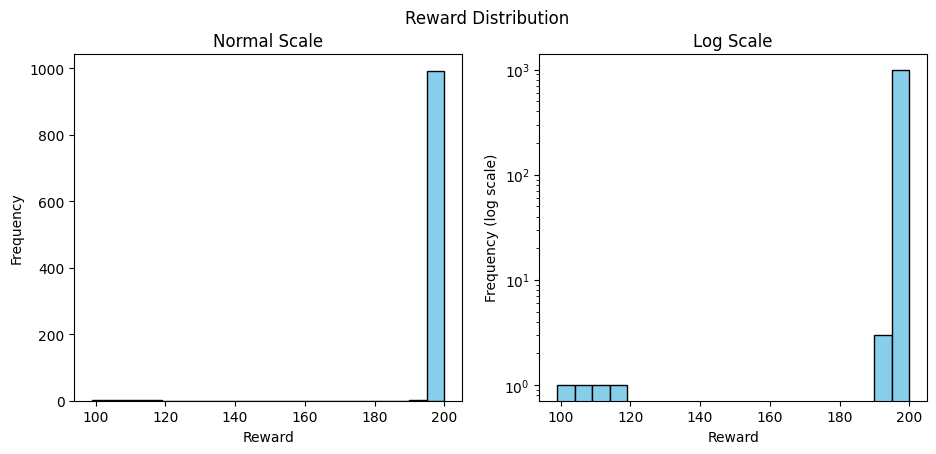

In [19]:
# visualize the reward distribution

def plot_reward_dist(rewards, title='Reward Distribution'):
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

    # histogram
    axes[0].hist(rewards, bins=20, color='skyblue', edgecolor='black')
    axes[0].set_title('Normal Scale')
    axes[0].set_xlabel('Reward')
    axes[0].set_ylabel('Frequency')

    # log-scaled histogram (for skewed distributions)
    axes[1].hist(rewards, bins=20, color='skyblue', edgecolor='black', log=True)
    axes[1].set_title('Log Scale')
    axes[1].set_xlabel('Reward')
    axes[1].set_ylabel('Frequency (log scale)')

    plt.suptitle(title)
    plt.show()

plot_reward_dist(expert_reward)

Running Policy...: 100%|██████████████████████████| 5/5 [00:16<00:00,  3.35s/it]


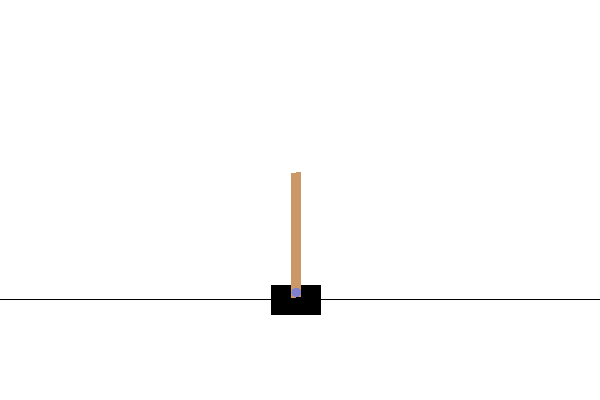

In [20]:
# Visualize policy in action

expert_reward = run_policy(bins, expert_Q, num_episodes=5, 
                           render=True, render_filename='../Results/Expert Policy [Q-Learning]')